In [122]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from matplotlib.animation import FuncAnimation
import numpy as np
from shapely import geometry
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(color_codes=True)
from mpl_toolkits.basemap import Basemap
import geopandas as gdp
from matplotlib import interactive
plt.style.use('bmh')
interactive(True)

In [120]:
df_dist_d = gdp.read_file('/Users/tjspross/Downloads/layer0_0_dense/')
df_dist_d = df_dist_d.to_crs({'init': 'epsg:4326'})
df_dist_c = gdp.read_file('/Users/tjspross/Downloads/layer0_0_central/')
df_dist_c = df_dist_c.to_crs({'init': 'epsg:4326'})

df_natline = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/natural_line.shp')
df_bound_line = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/boundary_line.shp')
df_highway = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/highway_line.shp')
df_waterway = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/waterway_polygon_polygon.shp')
df_bound_poly = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/boundary_polygon_polygon.shp')
df_bound_poly = df_bound_poly.loc[df_bound_poly['BOUNDARY']!='protected_area']
df_bound_poly = df_bound_poly.loc[df_bound_poly['ADMIN_LEVE']=='6']

In [ ]:
df = pd.read_json("/Users/tjspross/Documents/scrapy_smartshanghai/housing.json",lines=True)
# remove null or missing values
df = df.loc[~df['title'].isnull()]
df.loc[df['rooms']!='']

# filter by apartment types
df = df.loc[df['posted_type'].isin(['Apartment for rent','Shared apartment','House for rent','Service Apartment'])]

# truncate publish_time column into dates and months
df['publish_date'] = df['publish_time'].dt.date
df['publish_month'] = pd.to_datetime(dict(year=df['publish_time'].dt.year, month=df['publish_time'].dt.month, day=1))
df['pub_month'] = df['publish_month'].dt.month
df['publish_week']=(df['publish_time'] - pd.to_timedelta(df['publish_time'].dt.dayofweek, unit='d')).dt.date
# show dataframe

#create rooms columns
df['rooms'] = df['rooms'].str.replace(', [0-9]* Storage','').str.strip()
df.loc[df['rooms']=='']
df['rooms_BR'] = df['rooms'].str.extract('([0-9]*) Bedroom',0).fillna(0).astype('int')
df['rooms_BA'] = df['rooms'].str.extract('.*, ([0-9]*) Bathroom',0).fillna(0).astype('int')

df['rooms_simple'] = df['rooms_BR'].astype('str') + "BR, "+ df['rooms_BA'].astype('str') + "BA"

# filter for prices like 10,000 RMB or 10,000 rmb or 10,000 or RMB10,000
df = df.loc[df['price'].str.contains('^[0-9,]{3,} RMB$|^[0-9,]{3,} rmb$|^[0-9,]{3,}$|^RMB[0-9,]{3,}$')]
# strip unnecessary characters and convert to int
df['price']=df['price'].str.replace('RMB', '', case=True).str.replace(',','').str.strip().astype('int')


# remove sublets that appear in 'Apartments for rent'
sublets = df.loc[(df['description'].str.contains('overtake|leaving|take over|sublet|roommate|roomate|bedroom available')) & 
             (df['posted_type']=='Apartment for rent') &
            (df['rooms_BR']>=2) &
            (df['price']<10000)][['description','price','rooms','posted_type']]
sublets4= df.loc[(df['rooms_BR']>=4) & (df['price']<=8000) & (df['posted_type']=='Apartment for rent')]
sublets3= df.loc[(df['rooms_BR']==3) & (df['price']<=5000) & (df['posted_type']=='Apartment for rent')]

df = df.loc[~df.index.isin(sublets4.index)]
df = df.loc[~df.index.isin(sublets3.index)]
df = df.loc[~df.index.isin(sublets.index)]

for i in xrange(0,4):
    # filtering out top 2% apartments and bottom 1%
    upper_lim = df.loc[df['rooms_BR']==i]['price'].quantile(0.99)
    lower_lim = df.loc[df['rooms_BR']==i]['price'].quantile(0.01)
    df = df.loc[~((df['price']>upper_lim) & (df['rooms_BR']==i))]
    df = df.loc[~((df['price']<lower_lim) & (df['rooms_BR']==i))]
    
# Define columns
main_cols = ['area','author','description','floor','latitude',
             'longitude','listing_id','posted_type','price','publish_time','rooms','size','title']
checkbox_cols = ['air_filter','central_aircon','balcony','dryer','dvd_player','elevator',
                 'floor_heating','health_club','outdoor_space','oven','parking','playground','pool',
                'security','tv','wall_heating','washing_machine','water_filter']

# Show weeks in which we pulled the most data
weeks = df['publish_week'].value_counts()[0:6].index
weeks = weeks.sort_values()

df = df.loc[df['longitude'].astype('str')!='']
df = df.loc[df['latitude'].astype('str')!='']

In [124]:
def makegeoseris(value):
    return geometry.Point(value[0],value[1])
df['geometry']=df[['longitude','latitude']].astype('float').apply(makegeoseris,axis=1)
dfgeo = gdp.GeoDataFrame(df)

In [123]:
def checkarea(value,geoDataFrame):
    area = geoDataFrame.loc[geoDataFrame['geometry'].contains(geometry.Point(value[0],value[1]))]['TITLE']
    if area.empty:
        return None
    else:
        return area.tolist()[0]
# df['district'] = df[['longitude','latitude']].astype('float').apply(checkarea,args=(df_dist,),axis=1)
df['district_dense'] = df[['longitude','latitude']].astype('float').apply(checkarea,args=(df_dist_d,),axis=1)
df['district_central'] = df[['longitude','latitude']].astype('float').apply(checkarea,args=(df_dist_c,),axis=1)

In [125]:
def count_points(geoDataframe,groupby_col=None,output_col=None):
    counts=pd.DataFrame(geoDataframe.loc[~geoDataframe[groupby_col].isnull()][groupby_col].value_counts())
    counts.columns=[output_col]
    counts['TITLE']=counts.index
    counts.set_index("TITLE")
    return counts[output_col]
df_dist_d = df_dist_d.filter(regex='^(?!count)')
df_dist_c = df_dist_c.filter(regex='^(?!count)')
if df_dist_c.filter(regex='count').empty:
    df_dist_c = df_dist_c.join(count_points(dfgeo,'district_central','count'),on='TITLE')
    df_dist_c = df_dist_c.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==1],'district_central','count_1br'),on='TITLE')
    df_dist_c = df_dist_c.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==2],'district_central','count_2br'),on='TITLE')
    df_dist_c = df_dist_c.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==3],'district_central','count_3br'),on='TITLE')
    df_dist_c = df_dist_c.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==4],'district_central','count_4br'),on='TITLE')
if df_dist_d.filter(regex='count').empty:
    df_dist_d = df_dist_d.join(count_points(dfgeo,'district_dense','count'),on='TITLE')
    df_dist_d = df_dist_d.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==1],'district_dense','count_1br'),on='TITLE')
    df_dist_d = df_dist_d.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==2],'district_dense','count_2br'),on='TITLE')
    df_dist_d = df_dist_d.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==3],'district_dense','count_3br'),on='TITLE')
    df_dist_d = df_dist_d.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==4],'district_dense','count_4br'),on='TITLE')

In [128]:
df['publish_date'].value_counts()

2017-11-05    436
2017-11-14    425
2017-06-18    414
2017-06-29    400
2017-09-22    396
2017-11-03    387
2017-06-25    383
2017-06-28    382
2017-06-22    378
2017-09-27    371
2017-09-20    370
2017-09-13    367
2017-10-27    366
2017-06-23    366
2017-06-14    362
2017-11-15    360
2017-10-26    360
2017-11-16    360
2017-11-08    359
2017-10-24    355
2017-10-19    352
2017-10-23    352
2017-11-07    352
2017-09-14    347
2017-10-25    347
2017-10-18    345
2017-09-21    344
2017-09-12    343
2017-09-15    341
2017-11-17    340
2017-09-28    335
2017-10-20    335
2017-11-10    330
2017-11-19    328
2017-09-25    327
2017-09-18    327
2017-11-12    327
2017-06-27    323
2017-09-26    323
2017-09-17    321
2017-06-30    320
2017-07-10    318
2017-06-26    315
2017-11-09    315
2017-09-19    312
2017-11-06    311
2017-06-11    303
2017-11-02    303
2017-11-13    300
2017-06-12    297
2017-06-19    295
2017-09-29    292
2017-10-07    290
2017-09-11    285
2017-10-30    281
2017-11-18

In [126]:
def agg_price(func,rooms_br=None,groupby_col=None):
    if callable(func):
        func_name=func.__name__
    else:
        func_name=func
    price = pd.DataFrame(dfgeo.loc[
    (dfgeo['rooms_BR']==rooms_br) &
    (~dfgeo['posted_type'].isin(['Shared apartment','Service Apartment']))].groupby(groupby_col).agg(func)['price'])
    colname = "%s_%sbr"% (func_name,rooms_br)
    price.columns=[colname]
    price['TITLE']=price.index
    price[colname + "_text"] = price.apply(lambda x: "{:,.0f} CNY".format(np.round(x[colname]),0), axis=1)
    price=price.set_index('TITLE')
    return price
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def calc_price_cols(geoDataframe,groupby_col=None):
    if geoDataframe.filter(regex='median').empty:
        geoDataframe = geoDataframe.join(agg_price('median',rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('median',rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('median',rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('median',rooms_br=4,groupby_col=groupby_col),on='TITLE')
    if geoDataframe.filter(regex='mean').empty:
        geoDataframe = geoDataframe.join(agg_price('mean',rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('mean',rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('mean',rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('mean',rooms_br=4,groupby_col=groupby_col),on='TITLE')
    if geoDataframe.filter(regex='quant').empty:
        geoDataframe = geoDataframe.join(agg_price(percentile(10),rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(25),rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(75),rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(90),rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(10),rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(25),rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(75),rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(90),rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(10),rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(25),rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(75),rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(90),rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(10),rooms_br=4,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(25),rooms_br=4,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(75),rooms_br=4,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(90),rooms_br=4,groupby_col=groupby_col),on='TITLE')
    return geoDataframe

df_dist_c = calc_price_cols(df_dist_c.filter(regex='^(?!mean|median|percentile)'),groupby_col='district_central')
df_dist_d = calc_price_cols(df_dist_d.filter(regex='^(?!mean|median|percentile)'),groupby_col='district_dense')

elev = df.groupby('district_dense')['elevator'].agg(['sum','count'])
elev['perc_elev'] = elev['sum']/elev['count']
if df_dist_c.filter(regex='perc_elev').empty:
    df_dist_c = df_dist_c.join(elev['perc_elev'],on='TITLE')
if df_dist_d.filter(regex='perc_elev').empty:
    df_dist_d = df_dist_d.join(elev['perc_elev'],on='TITLE')    

/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [117]:
def round_and_combine(value):
    return tuple(np.round(value,3))
df['lat_long'] = df[['latitude', 'longitude']].apply(round_and_combine, axis=1)
df['lat_long'].value_counts()

TypeError: ("can't multiply sequence by non-int of type 'float'", u'occurred at index 0')

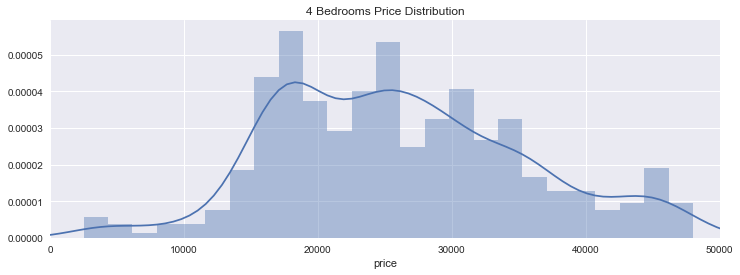

In [96]:
plt.figure(figsize=(12,4))
sns.set(color_codes=True)
sns.distplot(df.loc[(df['rooms_BR']==4) & (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],bins=25)
plt.title("4 Bedrooms Price Distribution")
plt.xlim(0,50000)
plt.show()

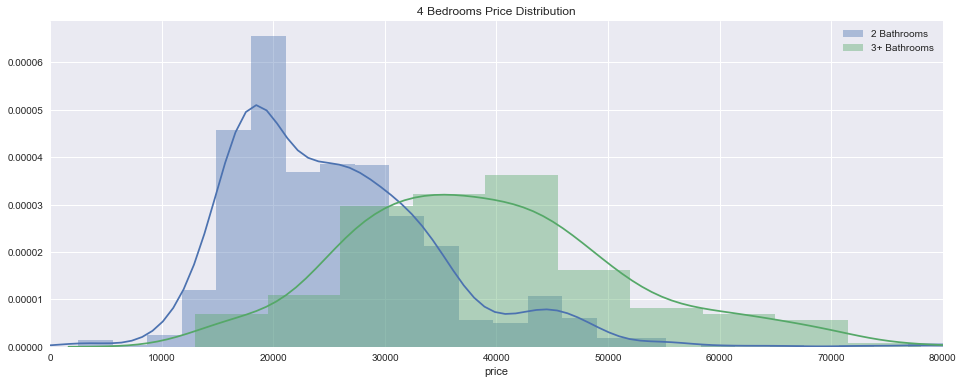

In [108]:
plt.figure(figsize=(16,6))
# sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']==1) & 
#                     (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
#              bins=25,label='1 Bathroom')
sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']==2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='2 Bathrooms') 
sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']>=3) & (df['price']<80000) &
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=10,label='3+ Bathrooms')
# sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']>3) & 
#                     (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
#              bins=50,label='4+ Bathrooms')
plt.title("4 Bedrooms Price Distribution")

plt.legend()
plt.xlim(0,80000)
plt.show()

In [107]:
df.loc[(df['rooms_BR']==4) & (df['rooms_BA']>=3) & (df['price']<80000)
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price']

TypeError: 'Series' object is not callable

In [88]:
df.loc[31887]['rooms']

u'2 Bedroom, 1 Bathroom, 1 Kids Rooms'

In [37]:
temp = df.loc[(df['rooms_BR']==4) & (df['price']<10000) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))][['description','rooms','posted_type','author']]

temp.to_csv('/Users/tjspross/Downloads/ss_temp.csv', encoding='utf-8')


In [125]:
df['description'].str.contains('french|French|laofang|Laofang').value_counts()
df['title'].str.contains('french|French|laofang|Laofang').value_counts()
df['area'].value_counts()


Xuhui                   6039
Jing'an                 5445
Huangpu                 2006
Changning               1981
Xujiahui                 886
Putuo                    858
-                        582
Pudong                   575
People's Square          219
Zhabei                   151
Hongkou                  130
Gubei                     93
Hongqiao                  80
Yangpu                    79
Minhang                   77
Bund Area                 65
Suzhou Creek              60
Old Town (Yu Garden)      50
Qingpu                    37
Baoshan                   25
Jiading                   17
Jinqiao                   15
Chongming                  9
Jinshan                    8
Songjiang                  7
Expo Area                  4
South Bund                 1
Anting                     1
Name: area, dtype: int64

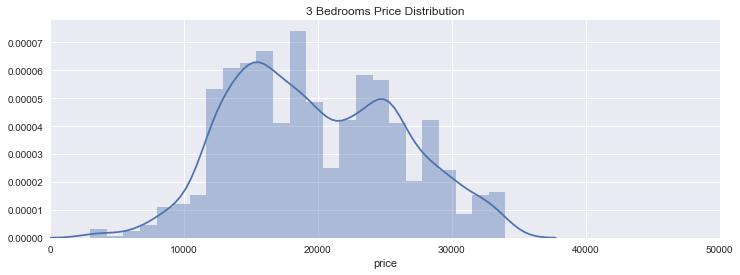

In [95]:
plt.figure(figsize=(12,4))
sns.distplot(df.loc[(df['rooms_BR']==3) & (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],bins=25)
plt.title("3 Bedrooms Price Distribution")
plt.xlim(0,50000)
plt.show()

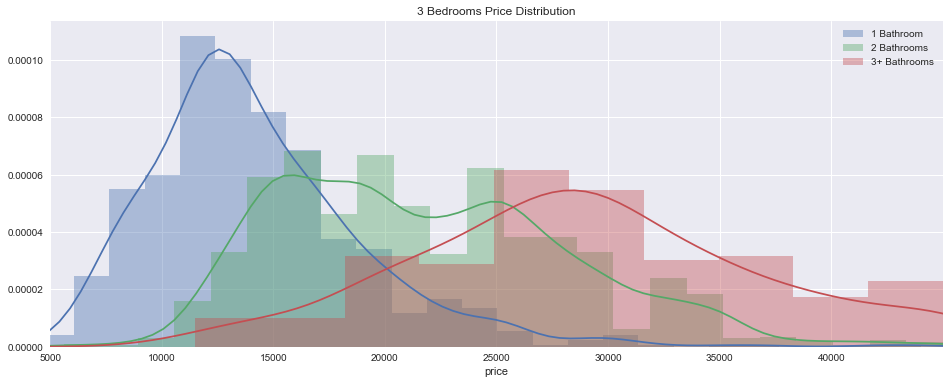

In [98]:
plt.figure(figsize=(16,6))
sns.distplot(df.loc[(df['rooms_BR']==3) & (df['rooms_BA']==1) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='1 Bathroom')
sns.distplot(df.loc[(df['rooms_BR']==3) & (df['rooms_BA']==2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='2 Bathrooms')
sns.distplot(df.loc[(df['rooms_BR']==3) & (df['rooms_BA']>2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=10,label='3+ Bathrooms')
plt.title("3 Bedrooms Price Distribution")
plt.legend()
plt.xticks(np.arange(5000,45000,5000))
plt.xlim(5000,45000)
plt.show()

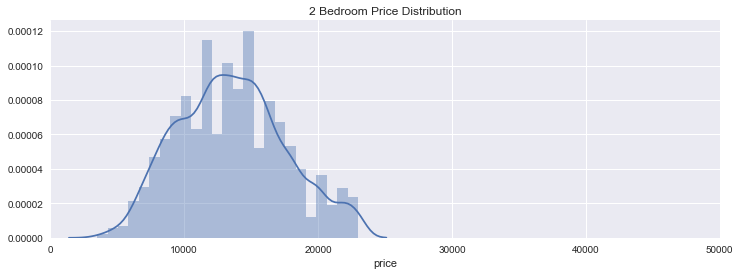

In [94]:
plt.figure(figsize=(12,4))
sns.set(color_codes=True)
sns.distplot(df.loc[(df['rooms_BR']==2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],bins=25)
plt.title("2 Bedroom Price Distribution")
plt.xlim(0,50000)
plt.show()

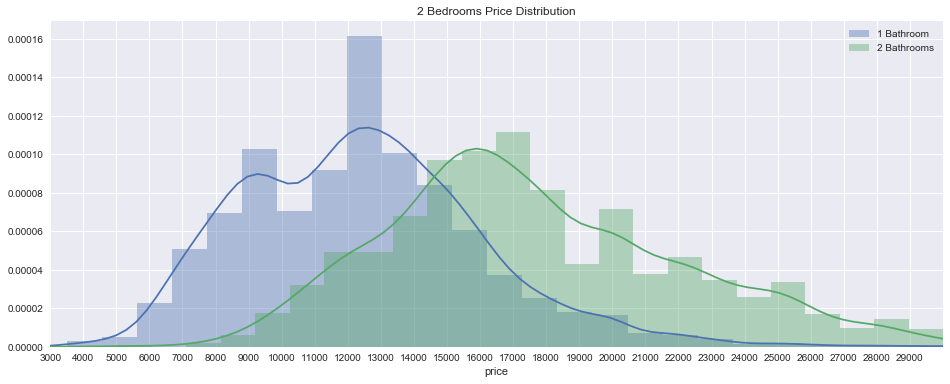

In [111]:
plt.figure(figsize=(16,6))
sns.distplot(df.loc[(df['rooms_BR']==2) & (df['rooms_BA']==1) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='1 Bathroom')
sns.distplot(df.loc[(df['rooms_BR']==2) & (df['rooms_BA']==2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='2 Bathrooms')
plt.title("2 Bedrooms Price Distribution")
plt.legend()
plt.xticks(np.arange(3000,30000,1000))
plt.xlim(3000,30000)
plt.show()

In [118]:
df.loc[(df['price']<6000) & (df['rooms_BR']==2) &
      (~df['posted_type'].isin(['Shared apartment','Service Apartment']))][['price','description','area','posted_type','size','rooms']]

,price,description,area,posted_type,size,rooms
136,5980,"Location :\r\nOn the Leshan road near west guangyuan road , there are many restaurants and pubs , many foreigners live there , please choose it choose the feeling at home .\r\n\r\nDetails :\r\nSunshine apartment , the bedroom face sorth , new decoration and new furnitures .\r\n\r\nPayment :\r\nThis price payment is 1 month deposit and 3 month rentals , if you want choose payment of 1 month deposit and 1 month rental , the price will rise 5% , and the landlord must receive service fee include wifi and Ayi clean apartment once per month , the service fee is 8% per month but must be paid by year .\r\n",Xuhui,Apartment for rent,70 sqm,"2 Bedroom, 1 Bathroom"
159,5420,"Location :\r\nOn the Yishan road near Kaixuan road , there are many restaurants and pubs , many foreigners live there , please choose it choose the feeling at home .\r\n\r\nDetails :\r\nSunshine apartment , the bedroom face sorth , new decoration and new furnitures .\r\n\r\nPayment :\r\nThis price payment is 1 month deposit and 3 month rentals , if you want choose payment of 1 month deposit and 1 month rental , the price will rise 5% , and the landlord must receive service fee include wifi and Ayi clean apartment once per month , the service fee is 8% per month but must be paid by year .\r\n",Xuhui,Apartment for rent,70 sqm,"2 Bedroom, 1 Bathroom"
1555,3500,"Full Apartment rent double floor Nice & Comfortable\r\navailable: \r\n-It is double floors space totally 80 square meters;\r\n-There are living room, opening kitchen, washing room and a small utility room in downstairs, the upstairs space can use for bed room, a glass balcony also in upstairs'.\r\n-With A/C/heat, well designed full furniture, microware and high speed wireless Internet connection, etc.\r\n\r\nIt is conveniently located within 3mins walking distance from baiyin road station of line 11 Jiading district. \r\n\r\nFacility: It is surrounded by restaurants, family mart, big supermarket, medicine store and Living facilities.\r\n\r\nRent is 3,500 rmb per month.(one month deposit at least 6 months leasing)\r\n\r\nMob: 13671700045\r\nwechat: caroltao001\r\nNOT FOR AGENCY\r\n\r\nKindly Regards\r\nCarol",Jiading,Apartment for rent,80 sqm,"2 Bedroom, 1 Bathroom"
2066,5500,"Location: \r\n- Located at East luochuan Rd cross Pingxing guan Rd, 12 mins walk to Line 1 (Yan chang rd).\r\n\r\n100% REAL PITURES AND PRICE\r\n\r\nCompound: Apartment\r\nType: Apartment\r\nFloor: 4th Floor \r\nLayout: 2BR+LR+1BA\r\nSize: 60sqm\r\nFurnishing: Fully furnitured\r\nAvailability: Available for move-in now\r\nLease term: At least 1 year\r\nMonthly Rent: RMB5500 including management fee",Zhabei,Apartment for rent,60 sqm,2 Bedroom
2271,5300,"It's so suit to who wants living on his/her own. So quiet, no brothering, forest-park surround, close to city center.\r\n\r\nA Golf park, big lake, scenic river & forest walking trail besides provides an quiet environment and variable happy things in your leisure time such as fishing, golf, running etc.\r\n\r\n24 hours security system\r\n\r\n2 bedroons, 1 living room, 1 washroom, 1 kitchen, 2 balconys.\r\na large princess bed, 2 TV, a large sofa, a large glass table, 4 chairs, air-conditioners. \r\n\r\n\r\nThe apartment located near Line 11 Nanxiang station. Gemdale Real Estate developped it as a big park like apartment close to city center. Also the apartment is managed by Gemdale property management office that provids on-site cleaning and other add-on services. \r\n\r\nMetro Line 11, Carrefour, commercial street (including Carrefour, CityShop, Starbucks, cinemas etc) are in 15 minutes walking. within 20 minutes can reach people's square or Hongqiao airport through express highwa...",Jiading,Apartment for rent,80 sqm,"2 Bedroom, 1 Bathroom"
2432,3800,"This lane house apartment / creative office is conveniently located on the ground floor inside old local Shikumen neighborhood, a couple minute walk from Madang road station or 10 mins to

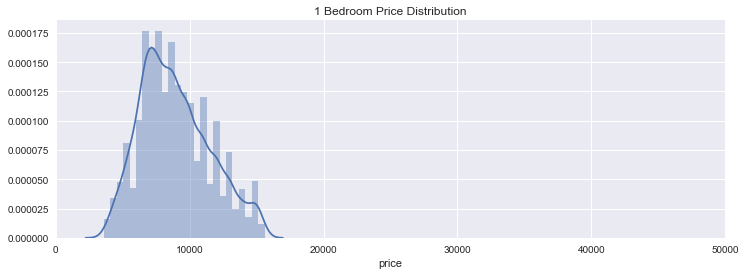

In [93]:
plt.figure(figsize=(12,4))
sns.set(color_codes=True)
sns.distplot(df.loc[(df['rooms_BR']==1) & (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],bins=25)
plt.title("1 Bedroom Price Distribution")
plt.xlim(0,50000)
plt.show()

In [67]:
df.loc[(df['rooms_BR']==2)]['posted_type'].value_counts()

Apartment for rent    6109
House for rent         172
Shared apartment       132
Service Apartment       27
Name: posted_type, dtype: int64

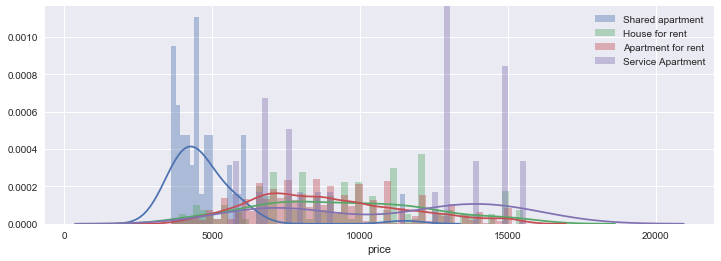

In [70]:
plt.figure(figsize=(12,4))
sns.set(color_codes=True)
sns.distplot(df.loc[(df['rooms_BR']==1) & (df['posted_type']=='Shared apartment')]['price'],bins=50,label='Shared apartment')
sns.distplot(df.loc[(df['rooms_BR']==1) & (df['posted_type']=='House for rent')]['price'],bins=50,label='House for rent')
sns.distplot(df.loc[(df['rooms_BR']==1) & (df['posted_type']=='Apartment for rent')]['price'],bins=50,label='Apartment for rent')
sns.distplot(df.loc[(df['rooms_BR']==1) & (df['posted_type']=='Service Apartment')]['price'],bins=50,label='Service Apartment')
plt.legend()
plt.show()

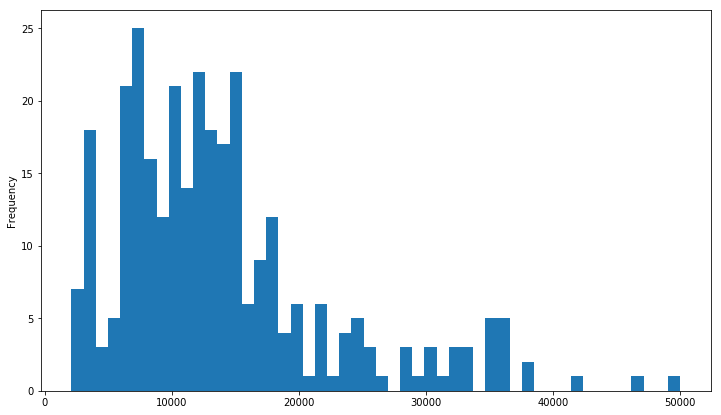

In [10]:
plt.figure(figsize=(12,7))
df.loc[df['publish_date'] == dt(2017,6,11).date()]['price'].plot.hist(bins=50)
plt.show()

In [11]:
plt.figure(figsize=(12,7))
plt.title('Week: %s' % weeks[1])
sns.distplot(df.loc[df['publish_week'] == weeks[1]]['price'], bins=50, kde=False)
plt.show()

NameError: name 'weeks' is not defined

In [72]:
import seaborn as sns
sns.set(color_codes=True)

plt.figure(figsize=(12,7))
plt.title('Week: %s' % weeks[4])
for i in xrange(1,4): #df['rooms_BR'].value_counts()[0:3].index:
    print i
    sns.distplot(df.loc[df['publish_week'] == weeks[4]].loc[df['rooms_BR']==i]['price'], bins=20, kde=False,label=str(i));
#     df.loc[df['publish_week'] == weeks[1]].loc[df['rooms_simple']==type]['price'].plot.hist(bins=50)
# df.hist(column='price',bins=50,by='rooms_simple')
# sns.distplot(df.loc[df['publish_week'] == weeks[1]].loc[~df['rooms_simple'].isin(top4_rooms)]['price'], bins=50, kde=False,label="other")
plt.legend()
plt.show()

NameError: name 'weeks' is not defined

In [ ]:



fig = plt.figure(figsize=(12,7))  
def update(i):
    plt.cla()

    plt.title('Week: {0}'.format(weeks[i]), fontsize=20)
    dfshow = df.loc[df['publish_week'] == weeks[i]]
    if not dfshow.empty:
        dfshow['price'].plot.hist(bins=50)

anim = FuncAnimation(fig, update, frames=np.arange(0,len(weeks)), interval=2000)

anim.save('line.gif', dpi=80, writer='imagemagick')

In [ ]:
import os
os.getcwd()

In [ ]:
plt.figure(figsize=(12,7))
df.loc[df['pub_month']==6]['price'].plot.hist(bins=50)
plt.show()


In [ ]:
plt.figure(figsize=(12,7))
df.loc[df['pub_month']==9]['price'].plot.hist(bins=50)
plt.show()

In [ ]:
900*20